In [1]:
#here we test all the components.

In [2]:
from logging import getLogger 
from eden.util import configure_logging
configure_logging(getLogger('root'),verbosity=1)

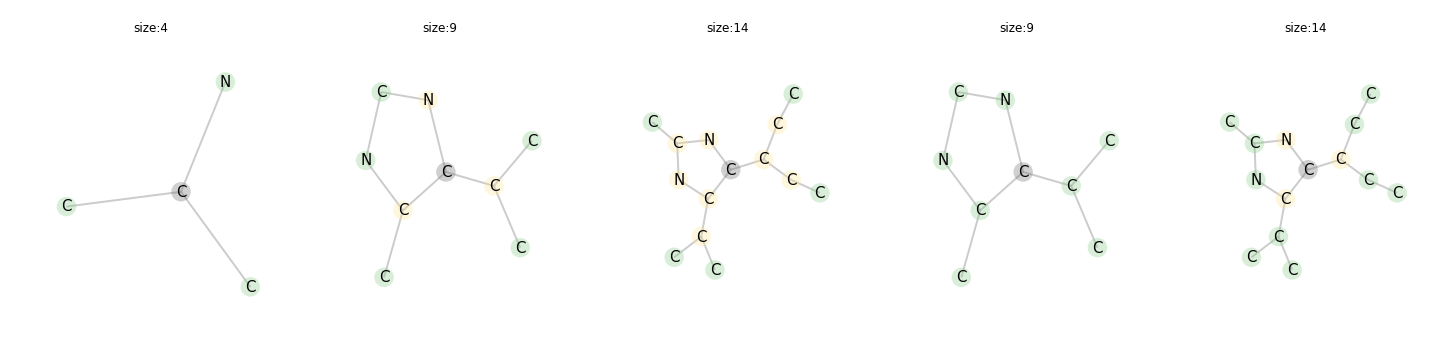

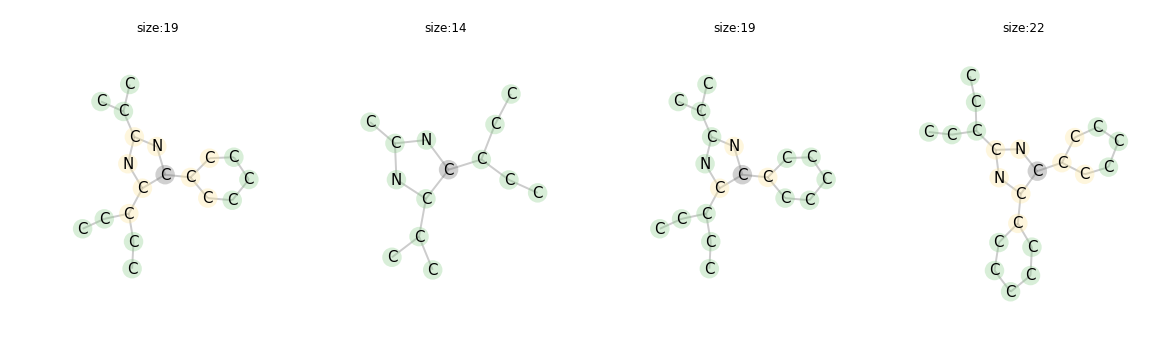

In [37]:

'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
g=gr.next()


#lets see..
a=gl.extract_core_and_interface(1,g,radius_list=[0,1,2],thickness_list=[1,2,3],vectorizer=myed.GraphLearnVectorizer())
ng=myutils.cip_to_graph(a) 
myutils.draw_graph_set(ng, n_graphs_per_line=5, size=5, colormap='Accent', invert_colormap=False,
                       vertex_alpha=0.3, edge_alpha=0.2, node_size=380)

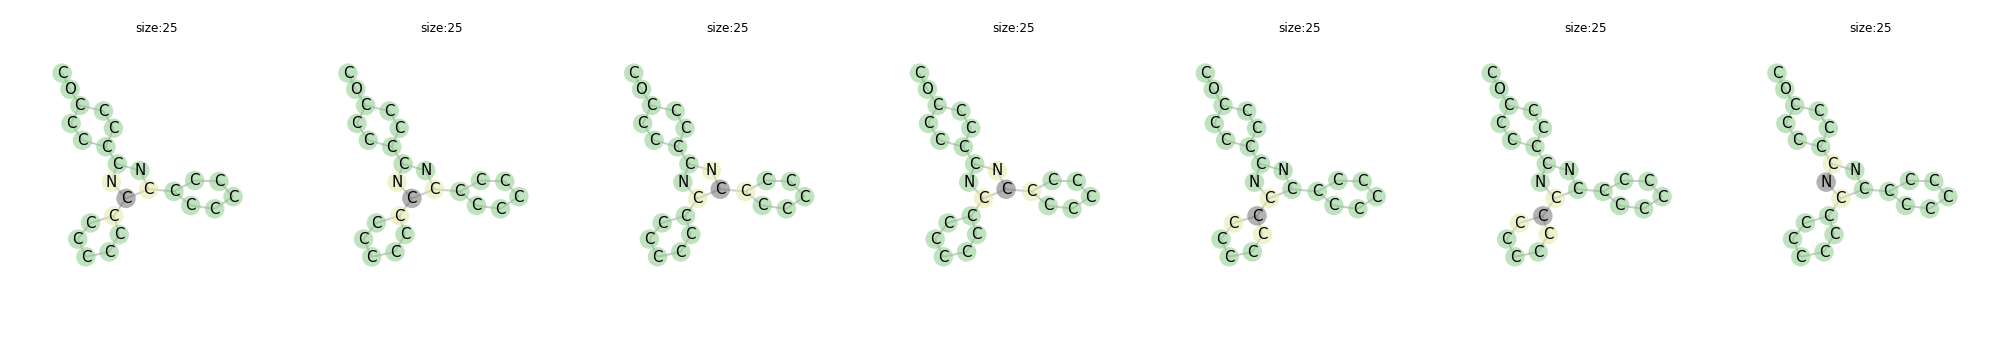

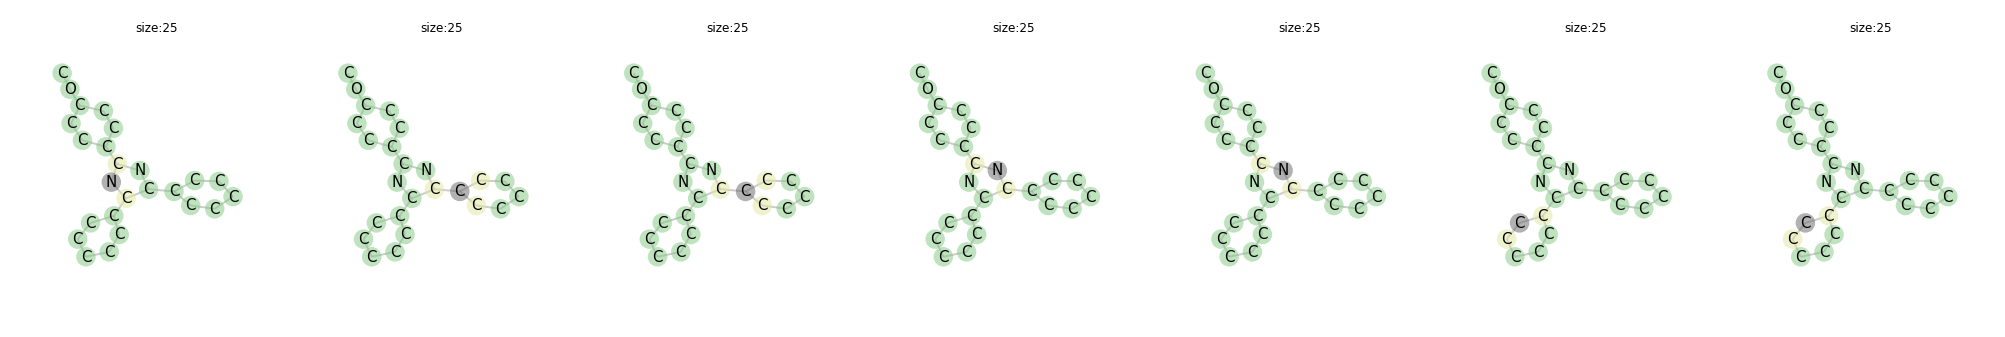

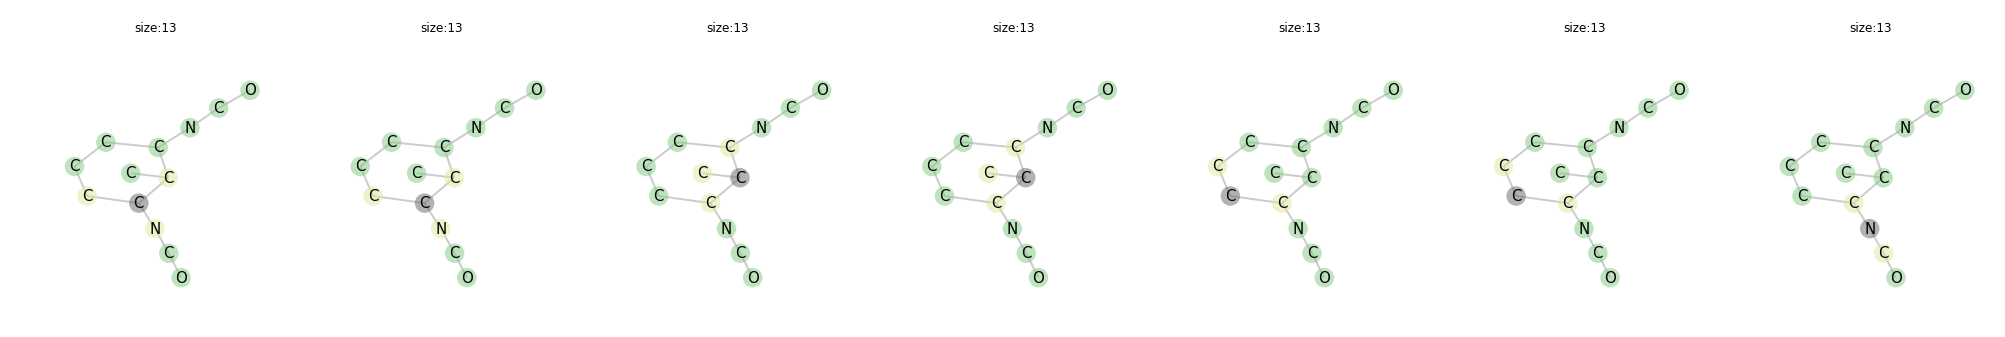

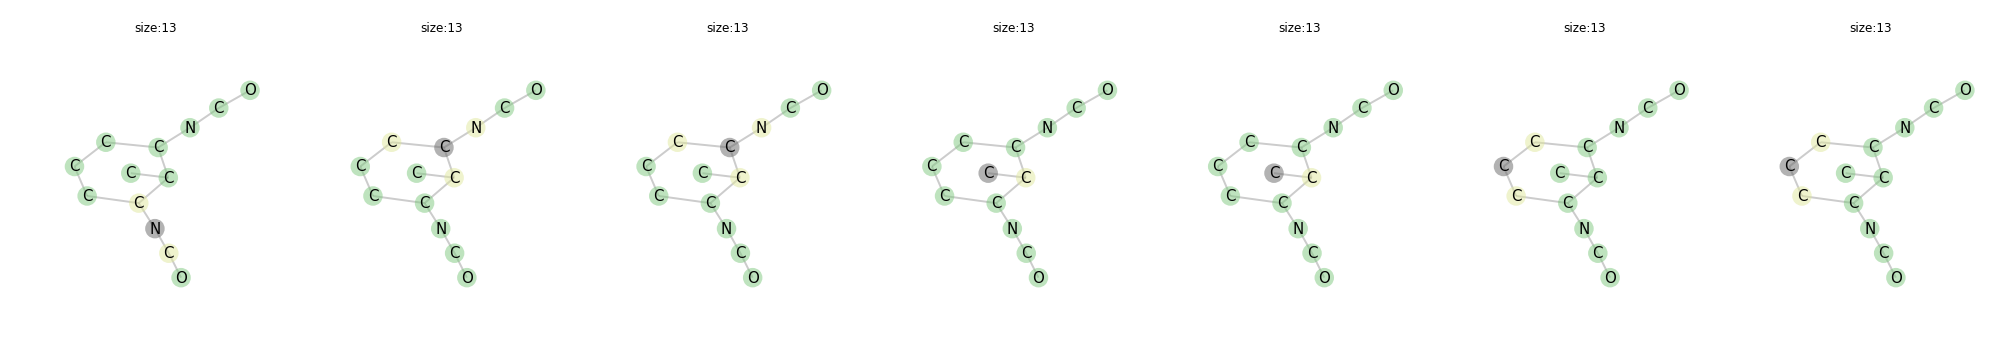

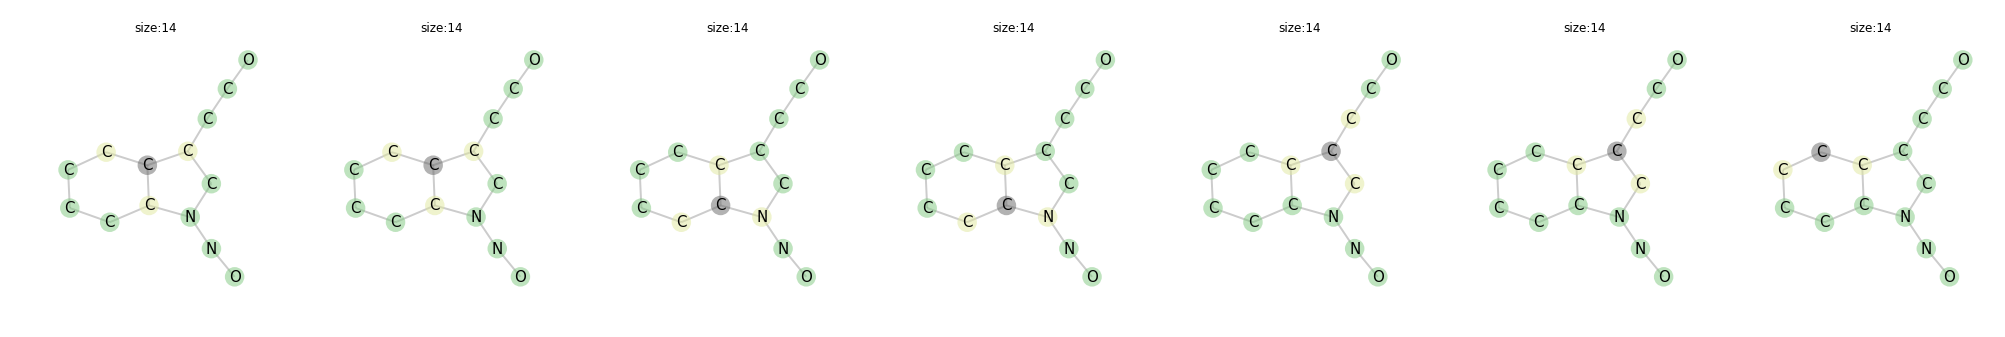

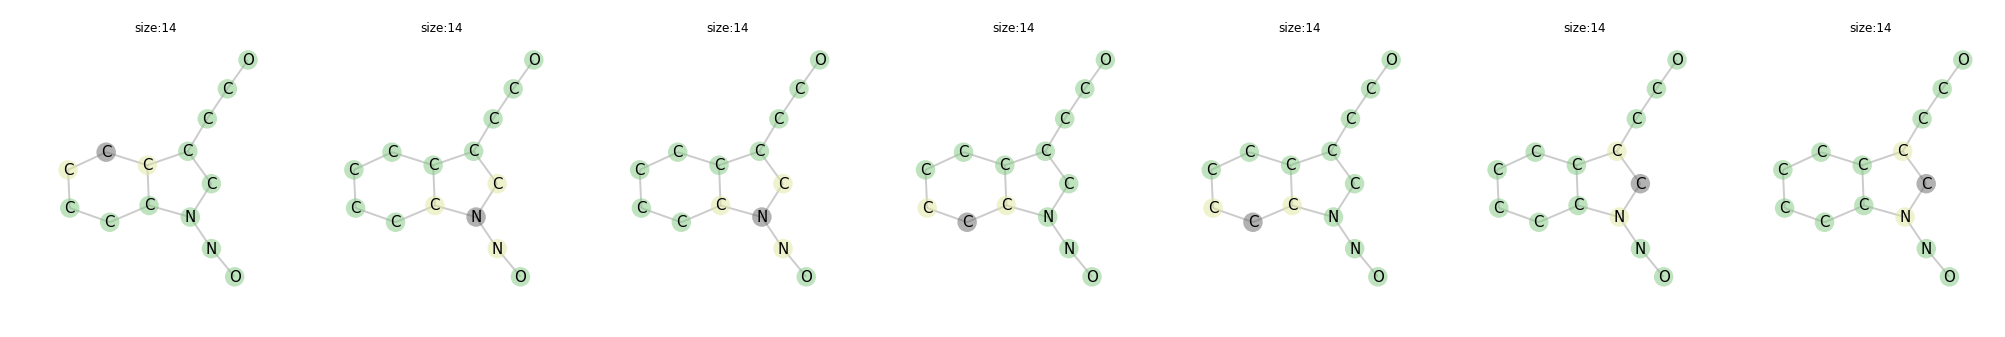

In [40]:
'''
demonstrating more extract core
'''
%matplotlib inline
import sys
sys.path.append('..')
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


gr = gspan_to_eden( 'bursi.pos.gspan' )
num=3
n_graphs_per_line=7
for x in range (num):
    g=gr.next()
    # for each, pick 5 cores and extract cips 
    nice_graphs=[]
    for n in range(n_graphs_per_line):
        node=n
        a=gl.extract_core_and_interface(node,g,radius_list=[0,1],thickness_list=[1,2],vectorizer=myed.GraphLearnVectorizer())
        # draw cip on the original graph and save in nice_graphs
        nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g]) 
        
    # draw nice_graphs
    myutils.draw_graph_set(nice_graphs, n_graphs_per_line=n_graphs_per_line, size=5, 
                           colormap='Accent', invert_colormap=False,
                           vertex_alpha=0.5, edge_alpha=0.2, node_size=380)

interface: 55058452


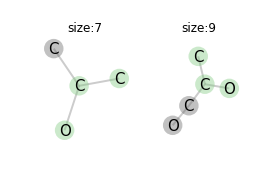

interface: 31129632


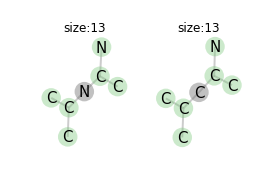

interface: 47071315


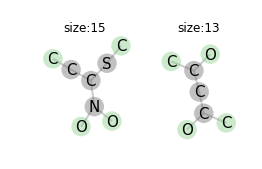

interface: 58794136


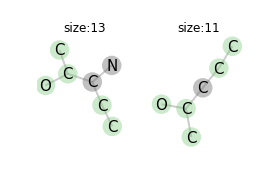

interface: 548896


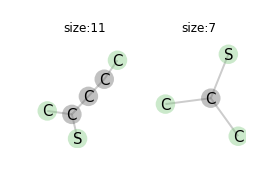

CPU times: user 6.5 s, sys: 1.04 s, total: 7.53 s
Wall time: 11 s


In [42]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
gr = gspan_to_eden( 'bursi.pos.gspan' )


# we just learn a grammar from 50 graphs..  
gr = itertools.islice(gr,100)
sampler=gl.GraphLearnSampler(radius_list=[0,1],thickness_list=[1,2])
#sampler=sampler.load('tmp/demo.ge')
sampler.fit(gr,n_jobs=-1)

# we look at the estimator and  draw 5 interfaces with their associated cores
#print sampler.estimator
sampler.save('tmp/demo.ge')
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=5,
                     n_graphs_per_line=n_graphs_per_line, size=2, 
                     colormap='Accent', invert_colormap=False,
                     vertex_alpha=0.4, edge_alpha=0.2, node_size=380)

how often do we see interfacehashes
# productions: 367
x = # interfaces (total: 99)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


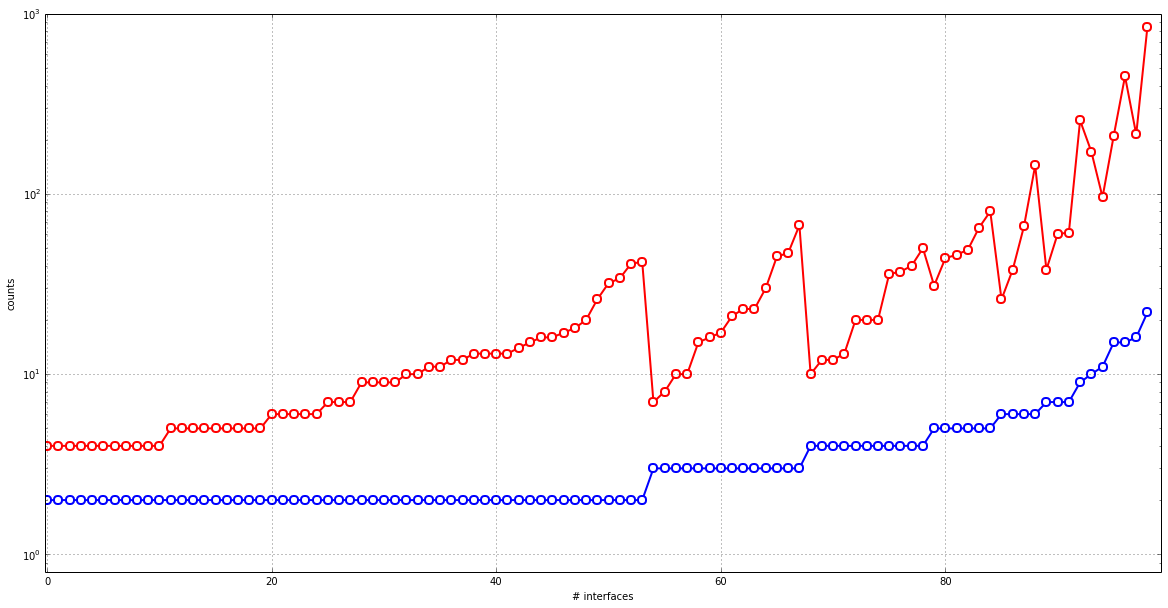

how often was this corehash seen?
x = # cores (total: 57)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


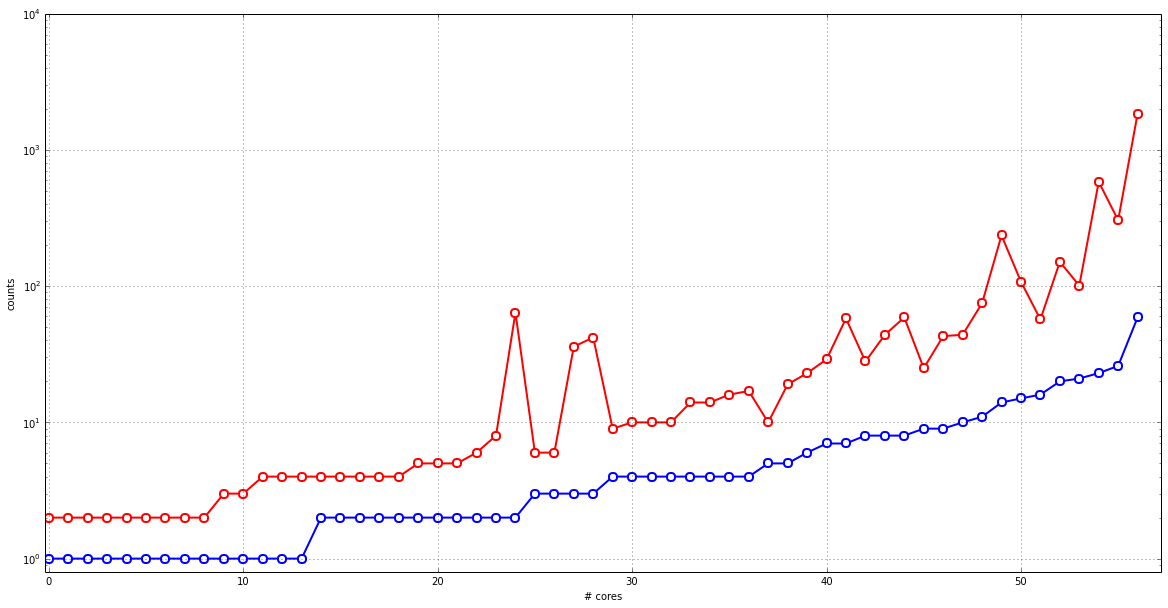

histogram
# productions: 367
distinct cores: 57 (seen on x axis)
interfaces with x many cores were observed y many times. 


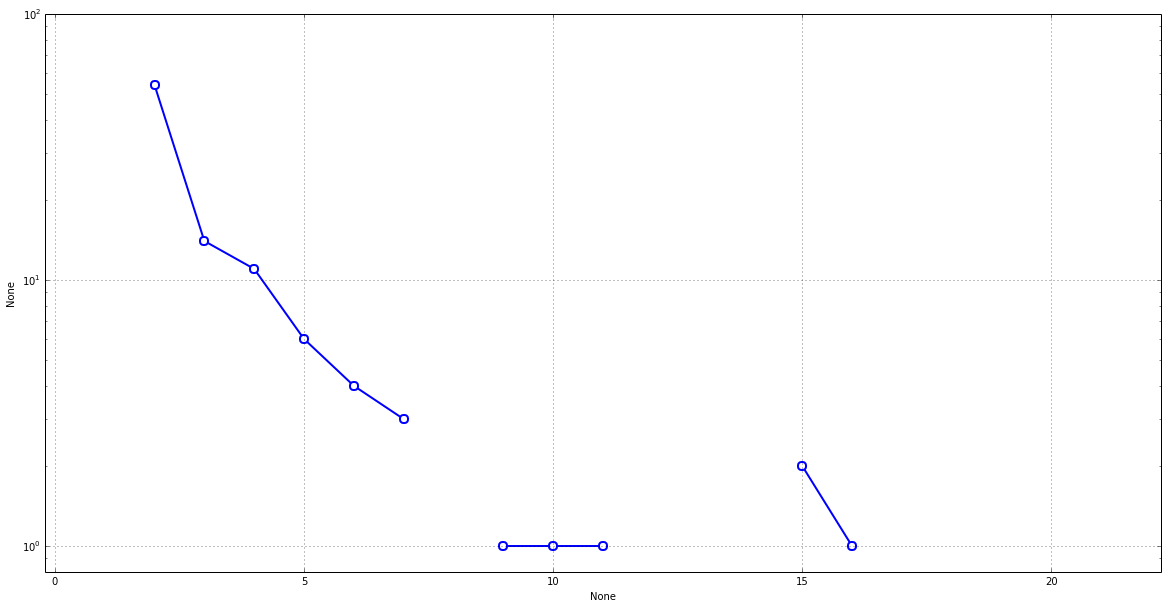

In [43]:
# here we look at some stats.
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar, size=(20,10))

loading done


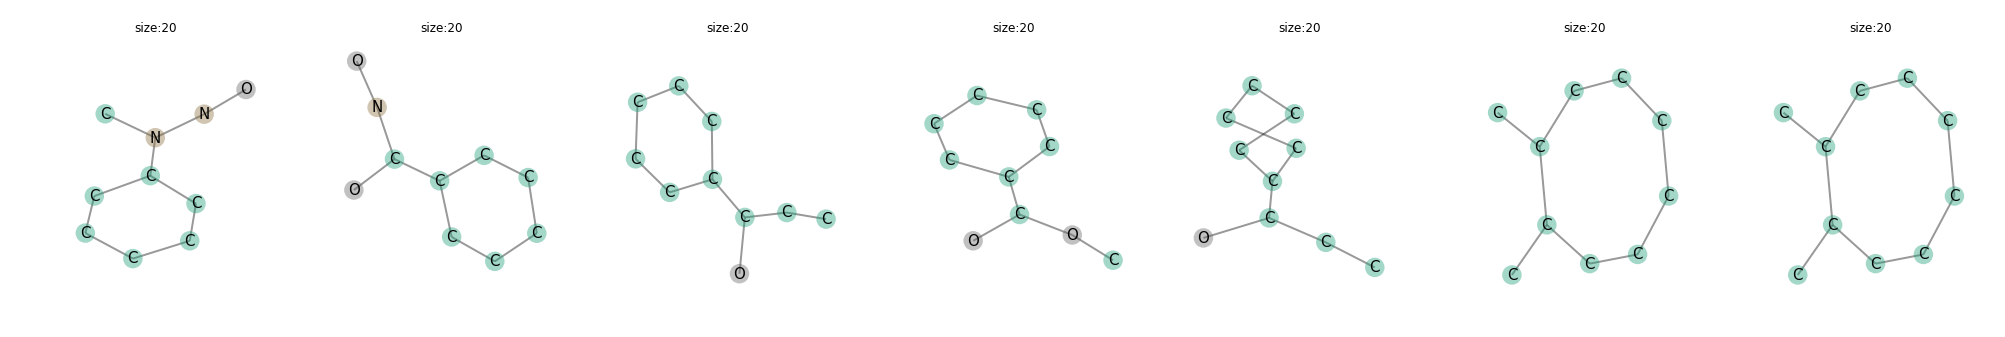

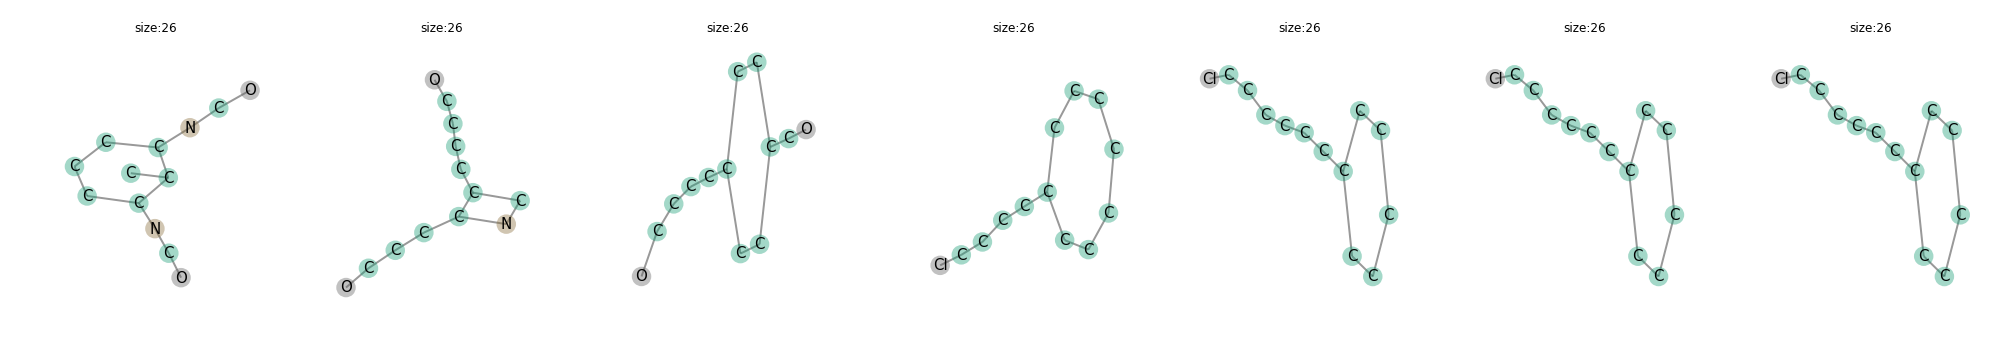

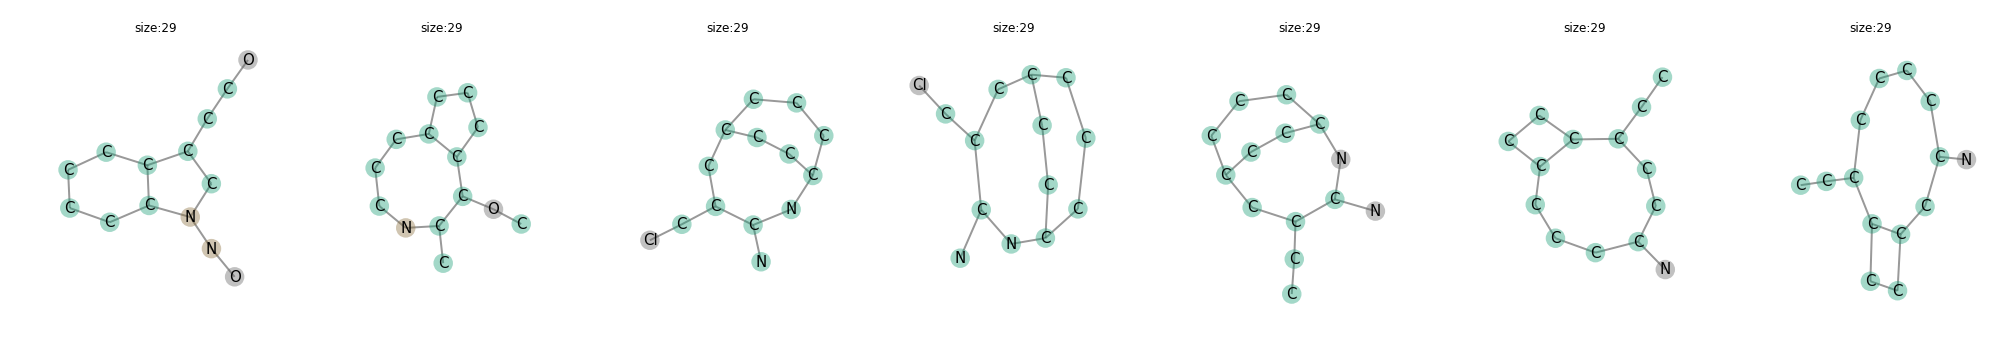

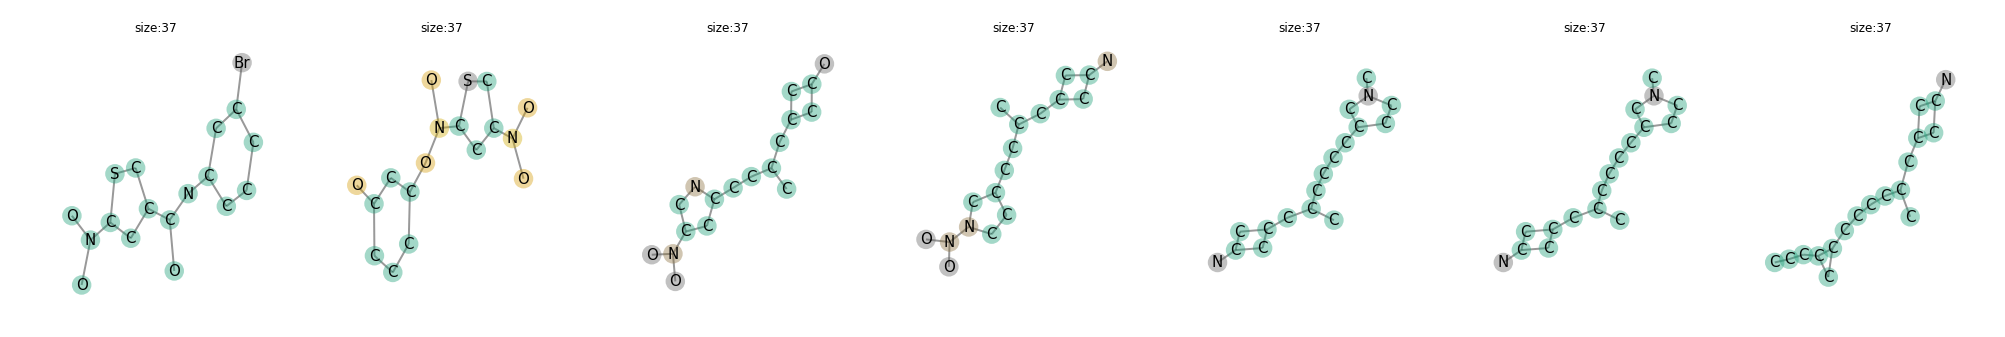

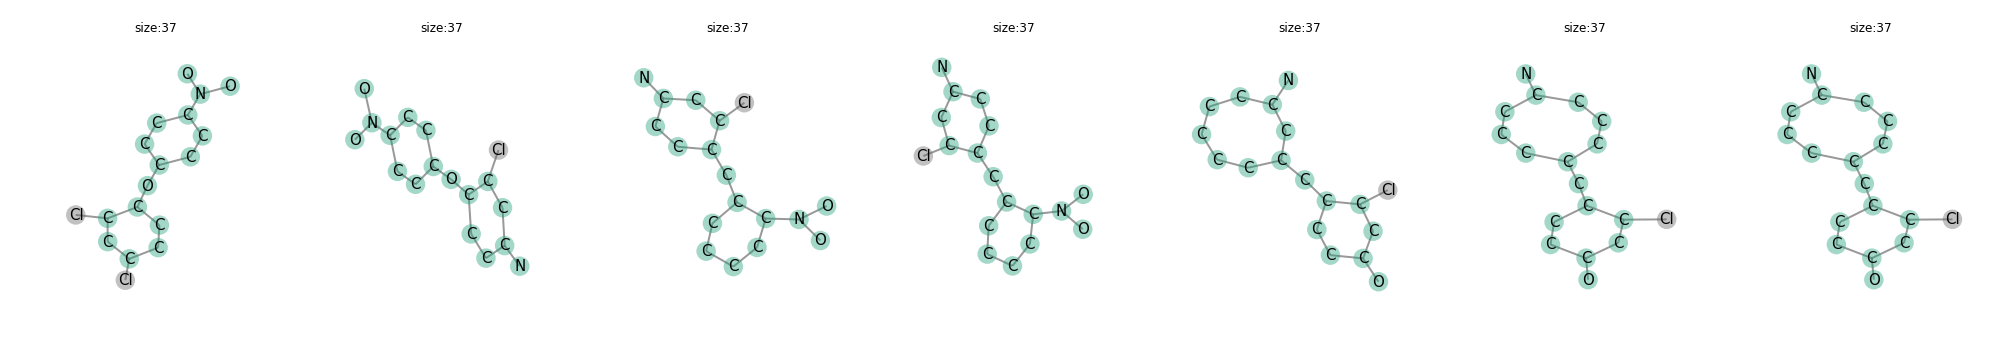

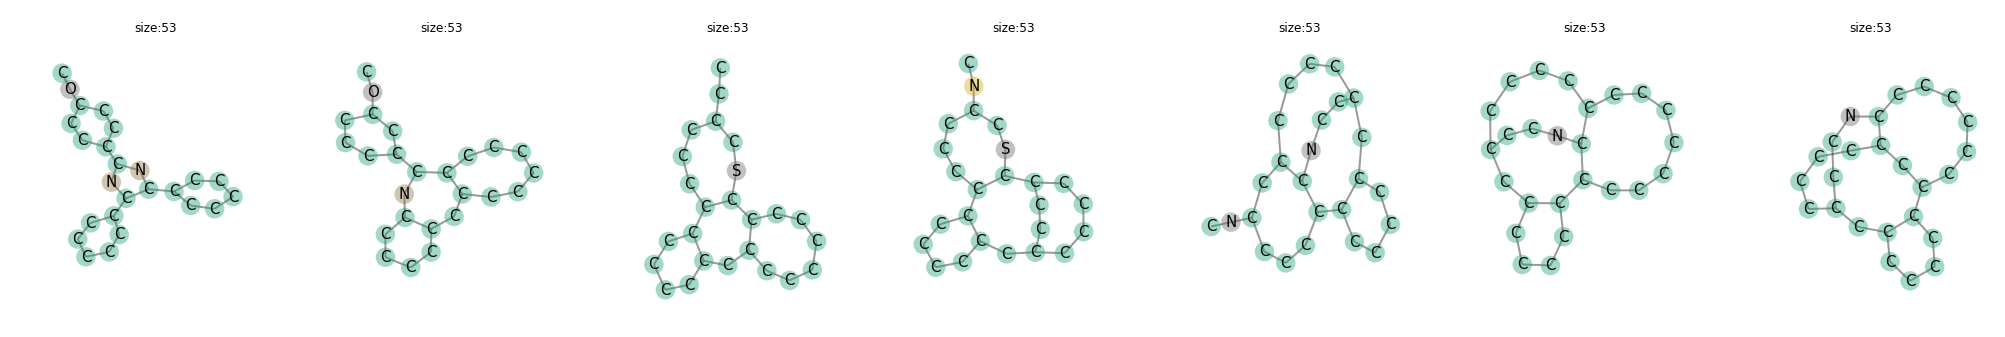

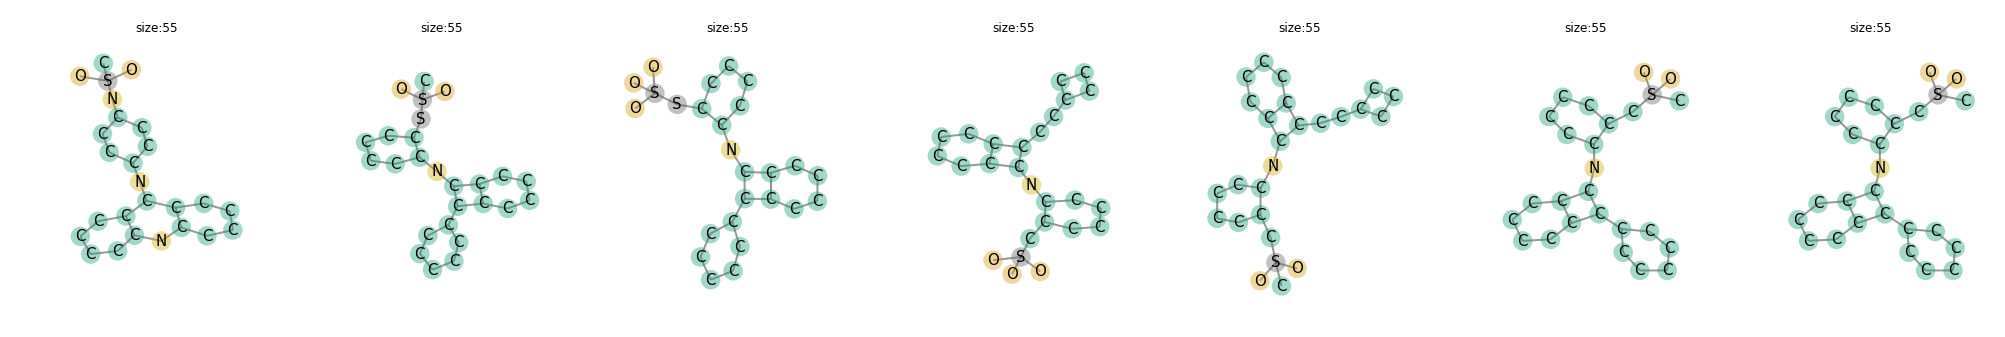

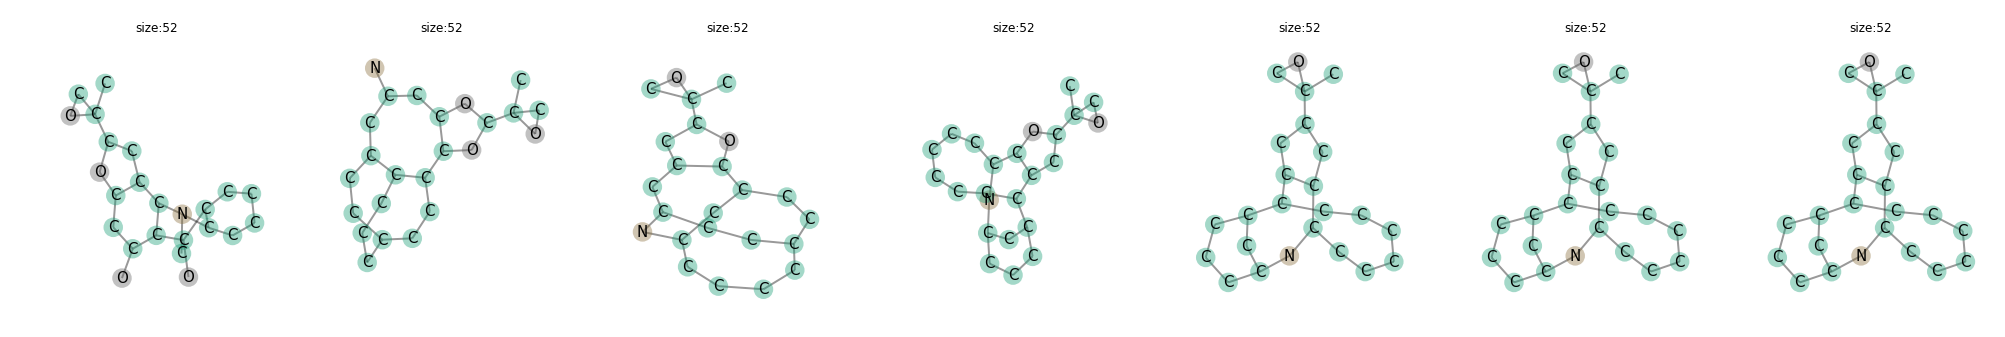

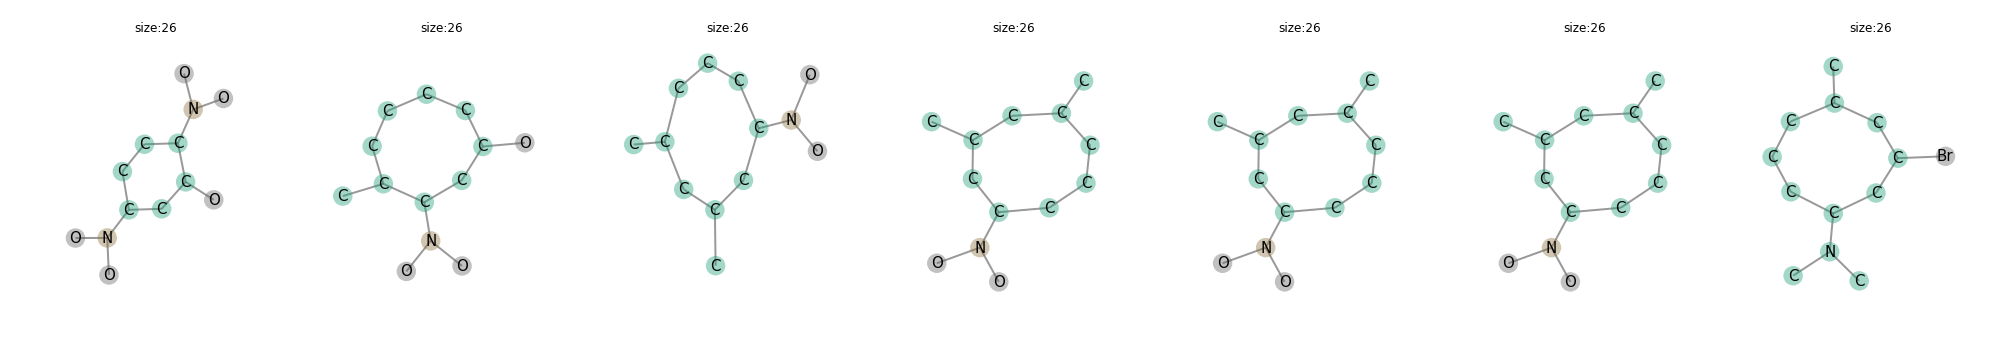

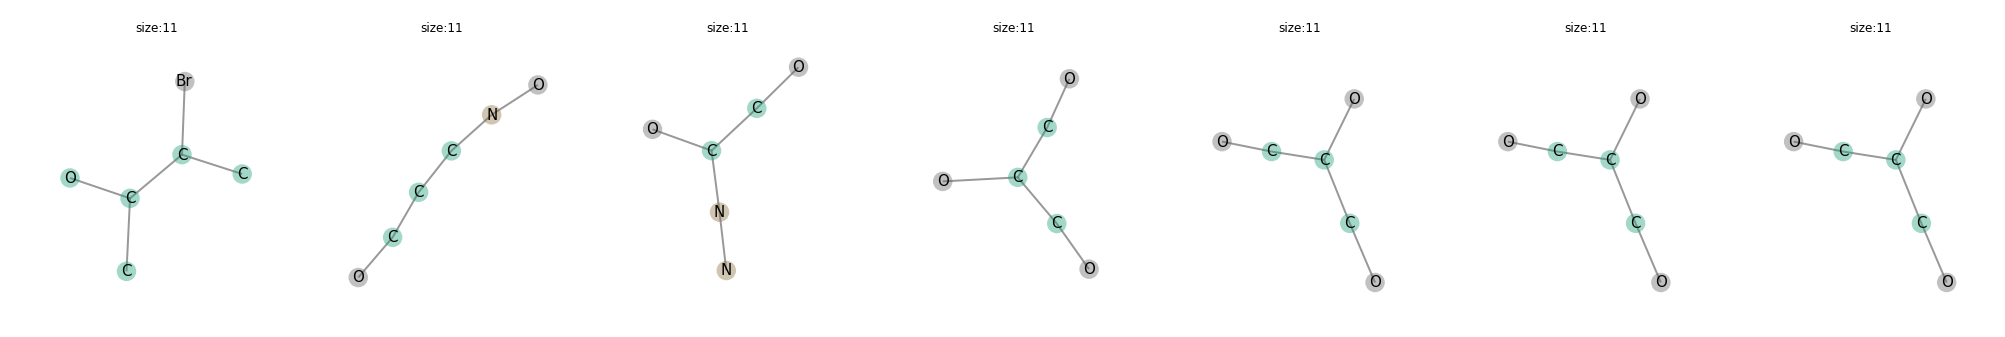

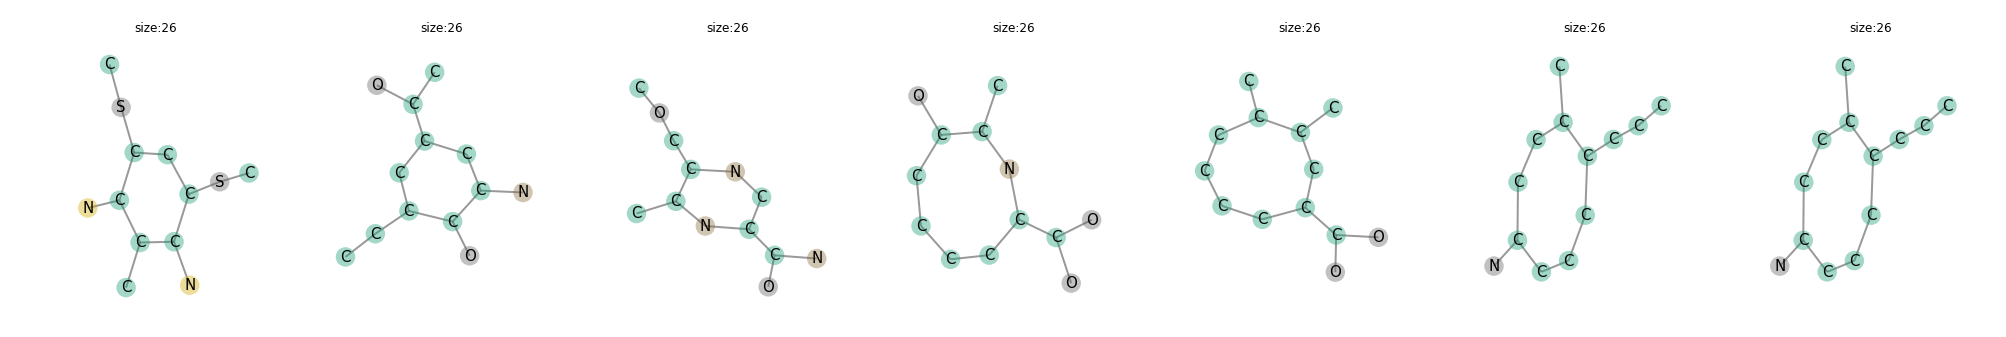

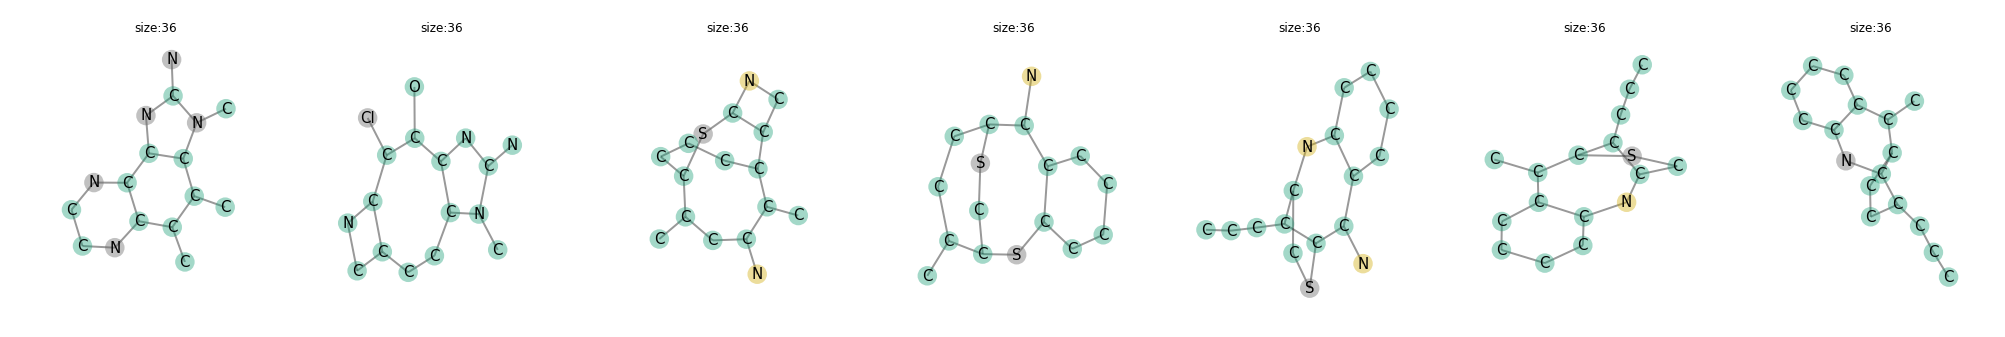

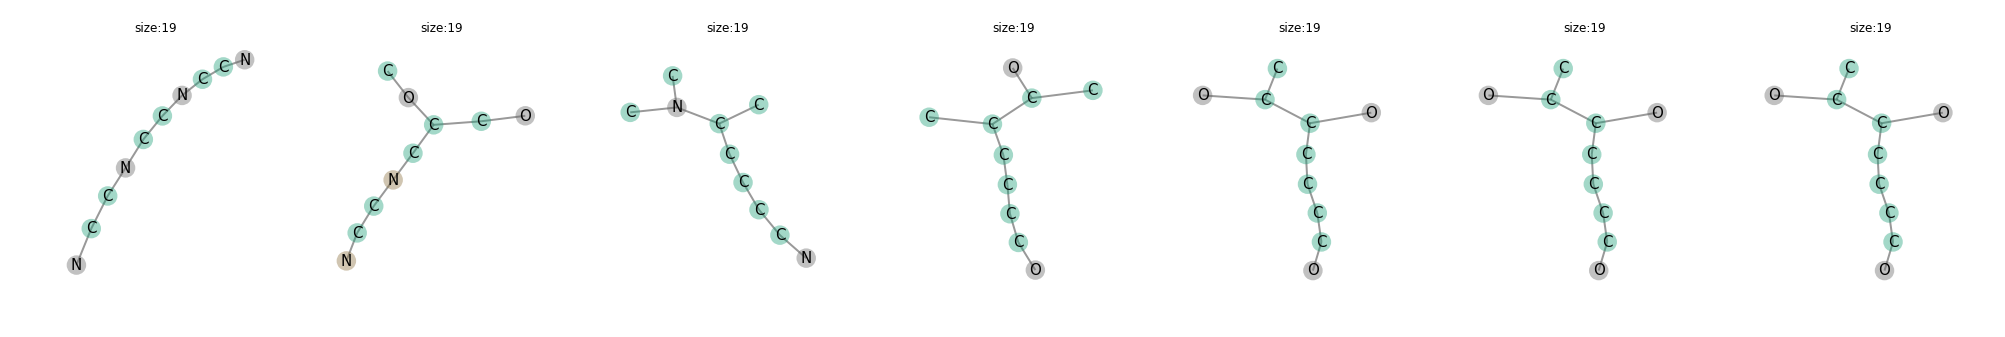

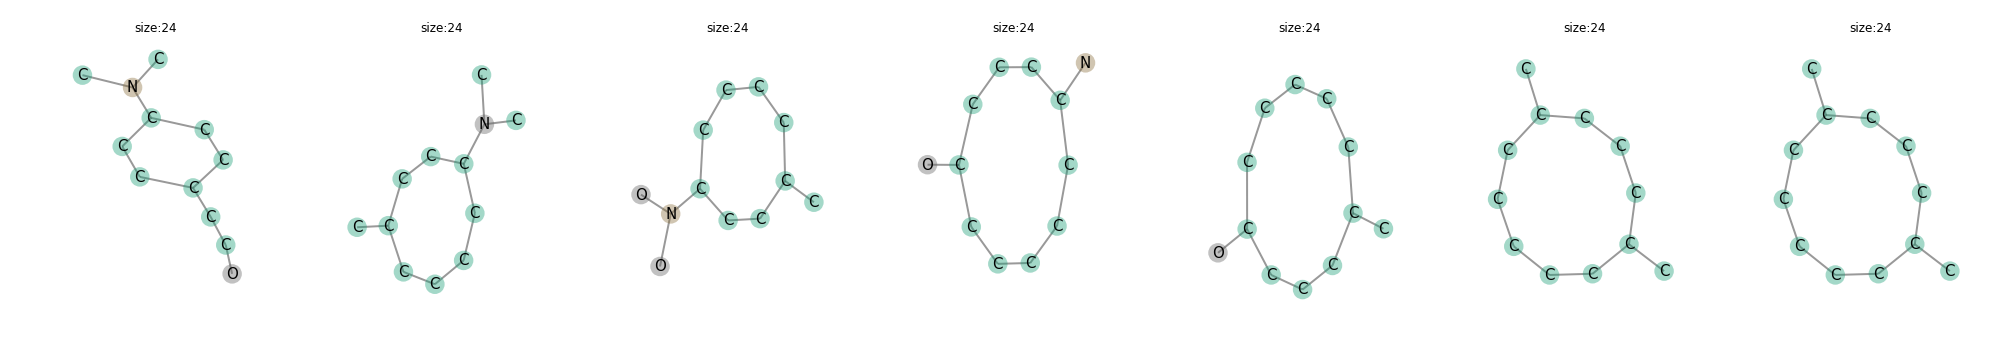

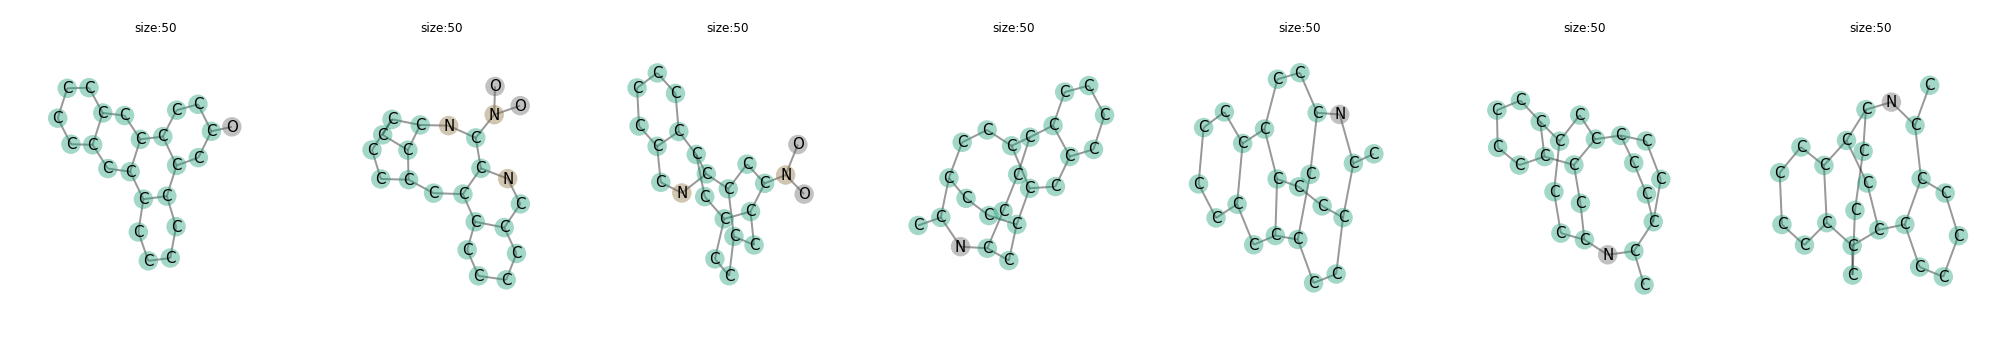

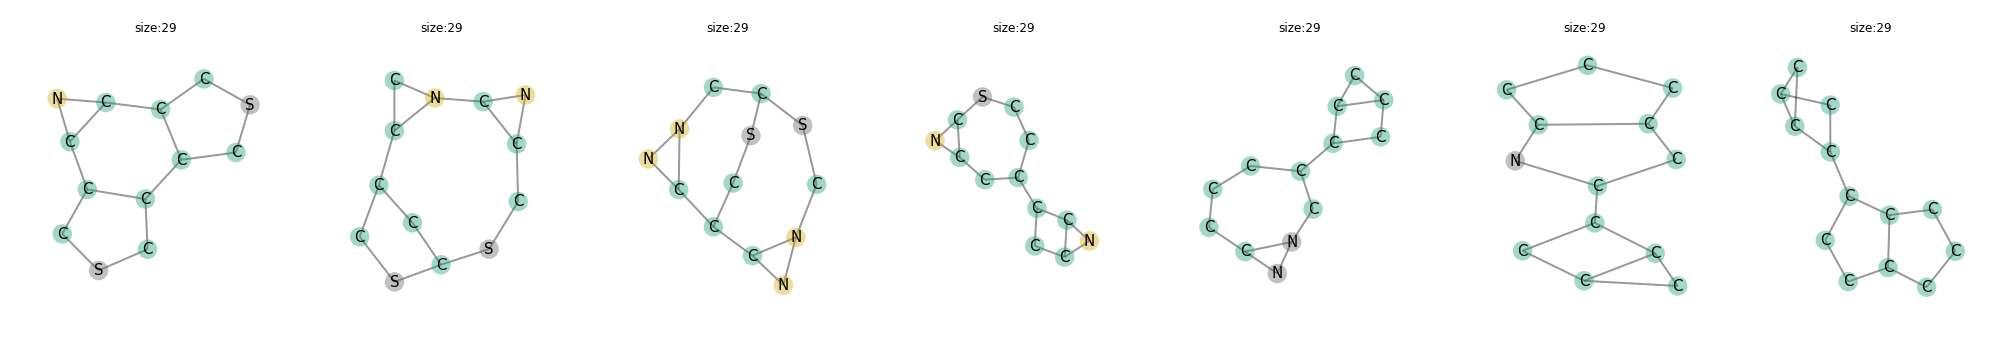

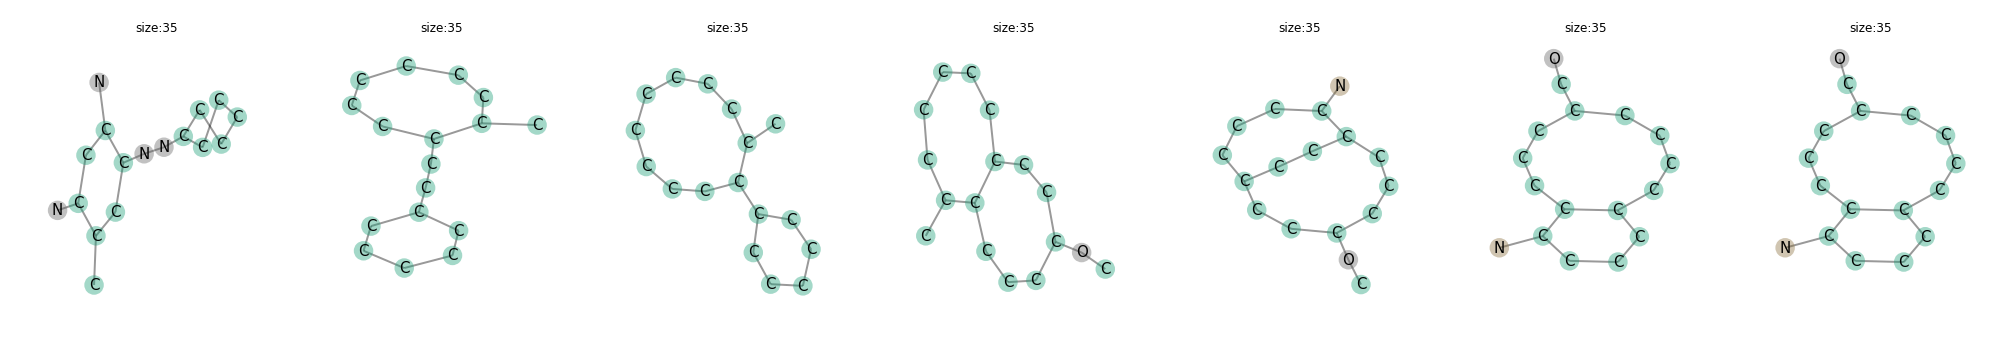

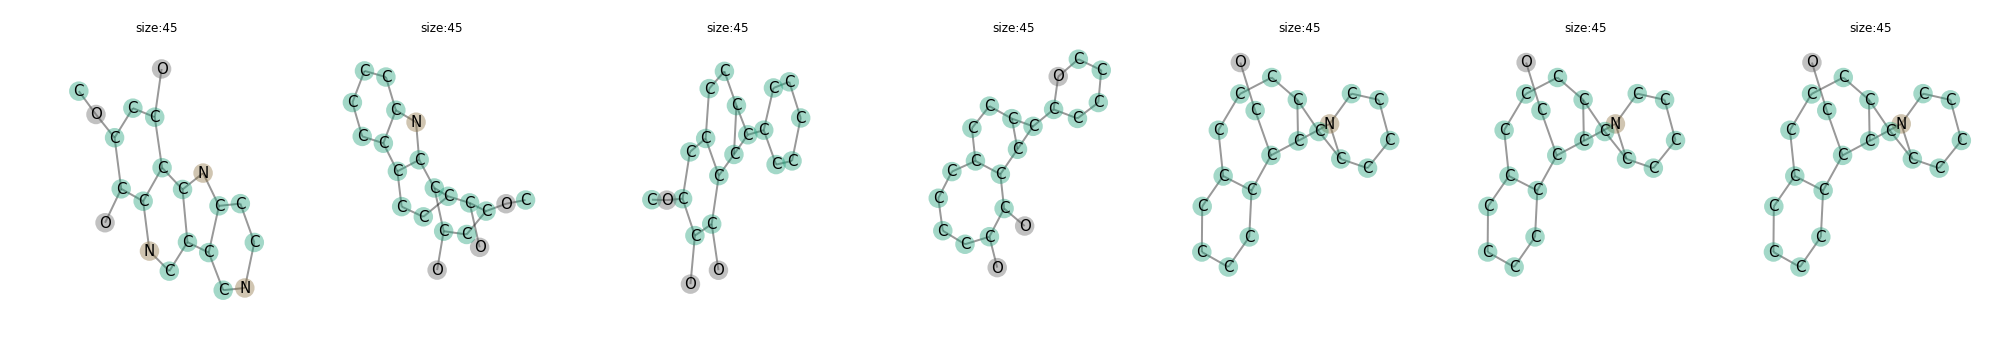

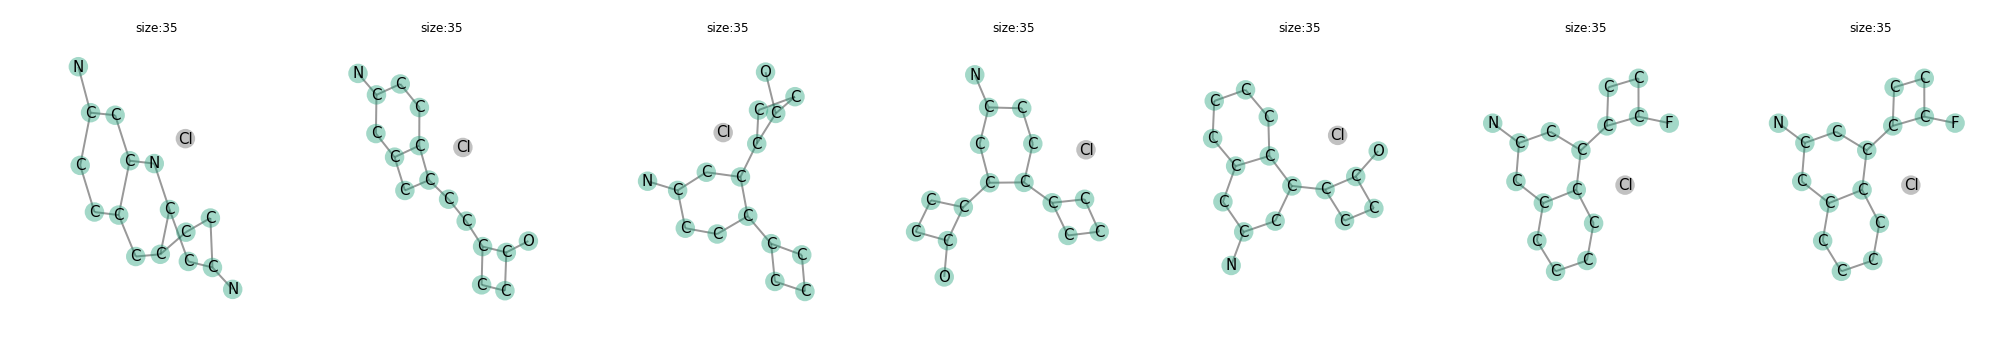

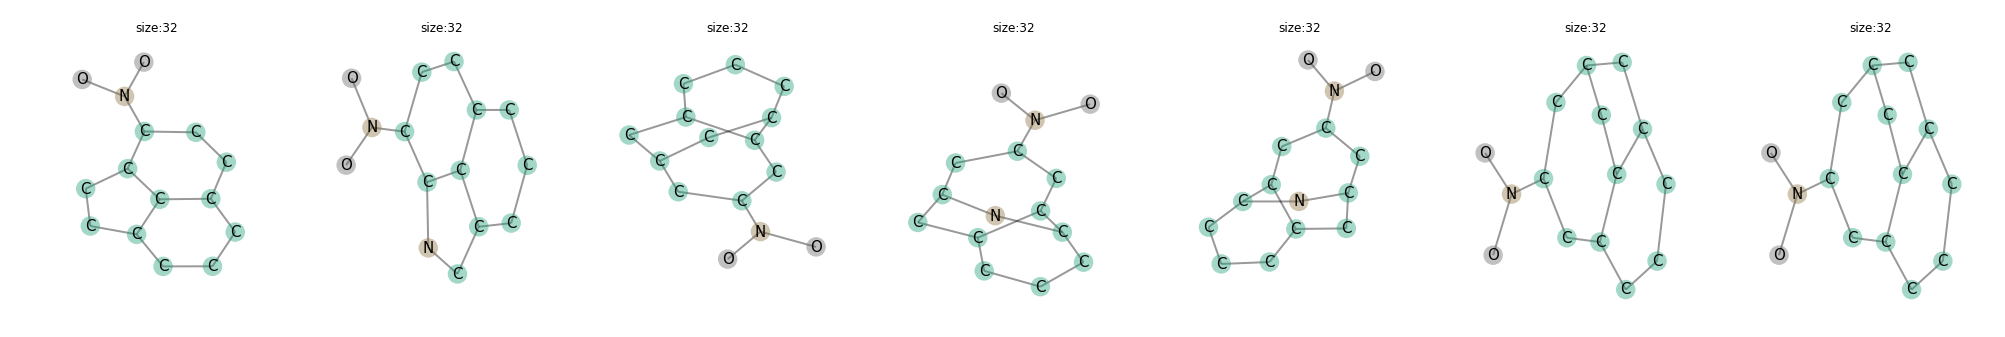

CPU times: user 31.7 s, sys: 3.83 s, total: 35.6 s
Wall time: 44.8 s


In [44]:
%%time
'''
now lets see if we can improve graphs
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt


n_steps=140
sampling_interval=int(n_steps/(n_graphs_per_line))
#sampling_interval=2

sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo.ge')
print "loading done"
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graphs = itertools.islice(graphs,20)
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=True,
                        sampling_interval=sampling_interval,
                        batch_size=1,
                        n_steps=n_steps-sampling_interval,
                        n_jobs=-1,
                        annealing_factor=1.5)

history=[]

for  i, (result,info) in enumerate(graphs):
    history.append(info['score_history'])
    myutils.draw_graph_set(info['graphs'], n_graphs_per_line=n_graphs_per_line, size=5, 
                           colormap='Dark2', invert_colormap=True, vertex_color='_labels_',
                           vertex_alpha=0.4, edge_alpha=0.4, node_size=380)

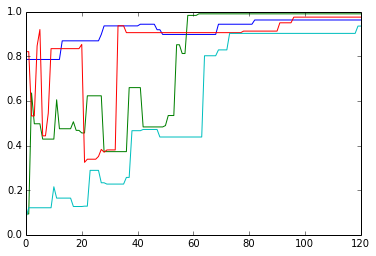

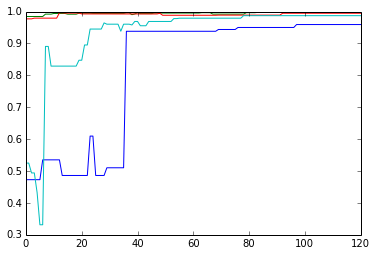

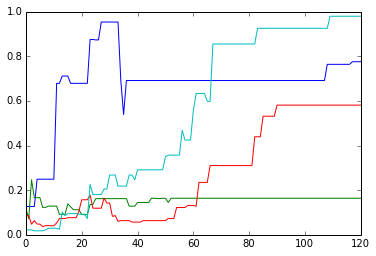

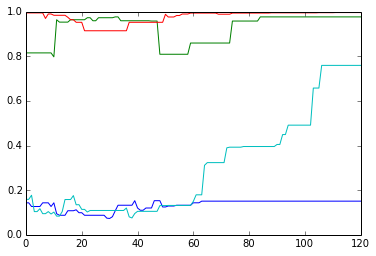

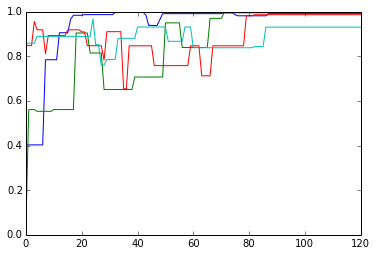

In [45]:
n_per_plot=4
n_plots=len(history)/n_per_plot
for i in range(n_plots):
    for h in history[i*n_per_plot:(i+1)*n_per_plot]:
        plt.plot(h)
    plt.show()

In [ ]:
%%time
'''
GOOD STUFF  lets test the clusterator
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline

import graphlearn.utils.draw as myutils
import graphlearn.cluster as cl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt




steps=500

sampler=cl.cluster()

#sampler.fit(gspan_to_eden( 'bursi.pos.gspan' ),  n_jobs=1)
#sampler.save('tmp/cluster.ge')
#print 'saved'
sampler.load('tmp/cluster.ge')



graphs = gspan_to_eden( 'bursi.pos.gspan' )
#graphs = itertools.islice(graphs,9)
graphs = sampler.sample(graphs,
                        sampling_interval=int(steps/3)+1,
                        batch_size=1,
                        n_steps=steps,
                        n_jobs=1,
                        select_cip_max_tries = 100,
                        annealing_factor=2.0,
                        doXgraphs= 9
                        )


history=[]
for  i, (result,info) in enumerate(graphs):
    history.append(info['score_history'])
    print info['notes']
    myutils.draw_many_graphs(info['graphs'])



t = range(steps+1) 
for h in history[:3]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[3:6]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[6:]:
    plt.plot(t, h)
plt.show()



In [7]:
print dir(history[0][0])
history.sum()

['T', '__abs__', '__add__', '__and__', '__array__', '__array_interface__', '__array_priority__', '__array_struct__', '__array_wrap__', '__class__', '__coerce__', '__copy__', '__deepcopy__', '__delattr__', '__div__', '__divmod__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getformat__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__hex__', '__init__', '__int__', '__invert__', '__le__', '__long__', '__lshift__', '__lt__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__oct__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rrshift__', '__rshift__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__setformat__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__trunc__', '__xor__', 'all', 'any',

AttributeError: 'list' object has no attribute 'sum'

# HERE BE NO DRAGONS


In [ ]:
'''
inform me when done !
'''
import os
os.system("( speaker-test -t sine -f 2000 )& pid=$! ; sleep 5.0s ; kill -9 $pid")

In [ ]:
'''TESTING HASH THINGS THERE ARE COLLISIONS'''
import networkx as nx
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline

import graphlearn.utils.draw as dr

import graphlearn.utils.myeden as myed
import graphlearn.graphtools as gt

vectorizer=myed.GraphLearnVectorizer()


def get_graph(nodelabels):
    g= nx.Graph()
    for e in nodelabels:
        nodes=len(g)
        #add nodes
        g.add_nodes_from(range(nodes,nodes+len(e)))
        #add edges
        for edid in range(nodes,nodes+len(e)-1):
            g.add_edge(edid,edid+1)
        #add labels
        for i,name in enumerate(e):
            g.node[nodes+i]['label']=name
            
    vectorizer._label_preprocessing(g)
    return g
        
        
g= get_graph (['C1N1','1C1C'])
f= get_graph (['1C2','C2','C2','O'])
dr.display(g,vertex_label='hlabel')
dr.display(f,vertex_label='hlabel')

print gt.calc_interface_hash(g, 2**20-1)
print gt.calc_interface_hash(f, 2**20-1)
        
        





